In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

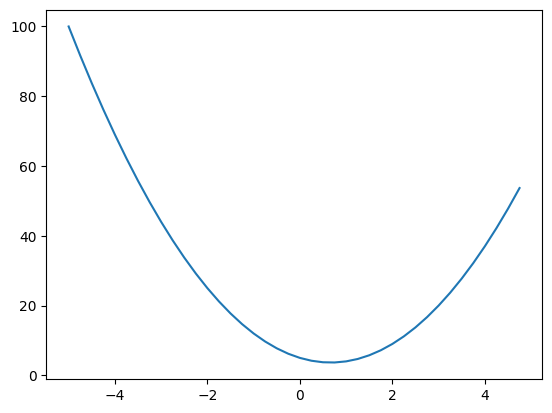

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [4]:
#!pip install graphviz
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [5]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [6]:
# Now let's add this to value class

class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0     # grad represents the derrivative of output (say L) wrt to value (say a or f)
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

            # this means the gradient is just copied as it is as 
            # we have seen it happening for addition            
        
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad          
        
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad          
        
        out._backward = _backward

        return out 

    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        self.grad += other * (self.data ** (other - 1)) * out.grad

        self.grad = 1.0 
        for node in reversed(topo):
            node._backward()


In [7]:
# Currently we cannot do integer addition directly, so, we will make change now
# We will do this for multiply

class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0     # grad represents the derrivative of output (say L) wrt to value (say a or f)
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
    
    
    def __repr__(self):
        return f"Value(data={self.data})"

    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)     # now, we can add integer directly
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

            # this means the gradient is just copied as it is as 
            # we have seen it happening for addition            
        
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other

    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad          
        
        out._backward = _backward

        return out


    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other*self.data**(other - 1)) * out.grad
        
        out._backward = _backward

        return out
    

    def __rmul__(self, other):  #other * self
        return self * other

    
    def __truediv__(self, other):
        return self * (other**-1)

    
    def __sub__(self, other):
        return self + (-other)  
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad     # exp(x) * out.grad
        
        out._backward = _backward
        
        return out


    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad          
        
        out._backward = _backward

        return out 

    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [8]:
a = Value(2.0)
b = Value(4.0)

print(a+1)
print(1+a)

print(a*2)
print(a/2)
print(a/b)

print(b**2)

print(b.exp())

Value(data=3.0)
Value(data=3.0)
Value(data=4.0)
Value(data=1.0)
Value(data=0.5)
Value(data=16.0)
Value(data=54.598150033144236)


**Division**

a / b

a * (1/b)

a * (b**-1)

Let's make:
x**k


In [9]:
a = Value(2.0)
b = Value(4.0)

a/b


Value(data=0.5)

## Breaking down tanh

In [10]:
# Let's see if everything works
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# Bias of a neuron
b = Value(6.88137358701954432, label="b")

# from figure we can see
# x1*w1 + x2*w2 + b

x1w1 = x1*w1; x1w1.label ="x1*w1"
x2w2 = x2*w2; x2w2.label ="x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "n" # Without activation function now

#o = n.tanh(); o.label = "output"
# ---------- tanh break-up ----------
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = "output"

# ---------- tanh break-up ----------


o.backward()

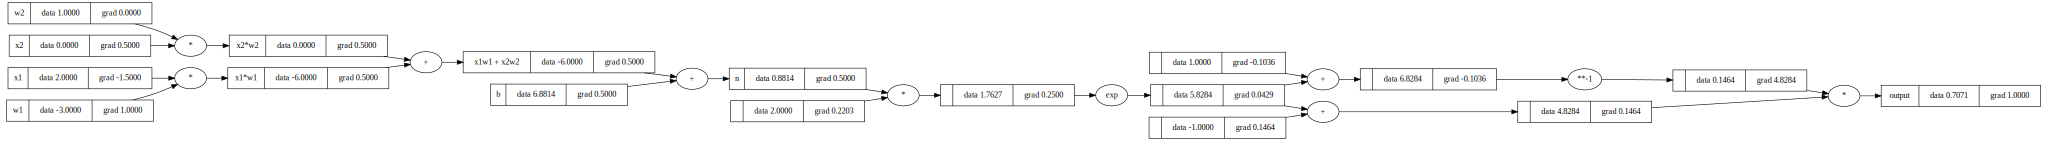

In [11]:
draw_dot(o)

The outputs of this resembles exactly the output if we directly use tanh fucntion. So, it doesn't matter how we implement operations. 

All that matters is we can correctly calulate the forward and backward pass.

#### Now the same thing is PyTorch

In [15]:
import torch

In [16]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

# The result is exactly the same

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# Building Neural Net(s) now